In [1]:
import graphviz
import numpy as np
import pandas as pd
from collections import OrderedDict
from sortedcollections import OrderedSet

In [2]:
# u = 'w'
# V = OrderedSet(sorted('wxyz'))
# edges = {
#     ('w', 'x'): 1,
#     ('w', 'y'): 2,
#     ('x', 'z'): 2,
#     ('y', 'z'): 1,
# }

# u = "a"
# V = OrderedSet(sorted("abcde"))
# edges = {
#     ("a", "b"): 2,
#     ("a", "c"): 1,
#     ("b", "e"): 1,
#     ("b", "d"): 4,
#     ("d", "c"): 8,
#     ("c", "e"): 6,
#     ("d", "e"): 1,
# }

u = "u"
V = OrderedSet(sorted("uvwxyz"))
edges = {
    ("u", "w"): 8,
    ("u", "v"): 5,
    ("u", "x"): 8,
    ("v", "x"): 9,
    ("v", "w"): 7,
    ("x", "w"): 1,
    ("x", "y"): 7,
    ("w", "z"): 3,
    ("w", "y"): 2,
    ("y", "z"): 4,
}

In [3]:
x = input()

u = x[0]
V = OrderedSet(sorted(filter(lambda f: "a" <= f <= "z", x)))
edges = {tuple(e): int(w) for *e, w in x.split(",")}

print(u)
print(V)
print(edges)

a
OrderedSet(['a', 'b', 'c', 'd', 'e'])
{('a', 'b'): 2, ('a', 'c'): 1, ('b', 'e'): 1, ('b', 'd'): 4, ('d', 'c'): 8, ('c', 'e'): 6, ('d', 'e'): 1}


In [4]:
class BiDict(OrderedDict):
    """https://stackoverflow.com/questions/1456373/two-way-reverse-map"""

    def __setitem__(self, key: tuple, value):
        if key in self:
            del self[key]

        OrderedDict.__setitem__(self, key, value)
        OrderedDict.__setitem__(self, key[::-1], value)

    def __delitem__(self, key):
        OrderedDict.__delitem__(self, key)
        OrderedDict.__delitem__(self, key[::-1])

In [5]:
class Node:
    def __init__(self, value, dist=0, prev=None):
        self.value = value
        self.dist = dist
        self.prev = prev  # predecessor node along path from source to self

    def __repr__(self):
        return self.value

    def __str__(self):
        return f"{self.dist},{self.prev!r}" if self.dist != np.inf else str(np.inf)

    def __getitem__(self, q):
        """Returns the dist from p to q if neighbors; otherwise, infinity"""
        return lookup[self][q]

    @property
    def neighbors(self):
        return OrderedSet(filter(lambda u: (self.value, u.value) in E, G))

In [6]:
def check(path):
    """Checks if a tree is acyclic and connected"""
    G = {n: set(v for u, v in path if u == n) for n in V}

    def dfs(source):
        stack, visited = list(source), set()
        while stack:
            visited.add(n := stack.pop())
            stack.extend(G[n])
            if any(n in visited for n in stack):
                raise Exception("cycle found")
        if V != visited:
            raise Exception(f"nodes {V - visited} were not connected")

    try:
        dfs(u)
    except Exception as e:
        print(e)

In [7]:
init = Node(value=u)

E = BiDict(**edges)
graph = OrderedSet(
    map(lambda v: Node(value=v, dist=E.get((u, v), np.inf), prev=init), V - {u})
)
visited = OrderedSet({init})

G = visited | graph
lookup = OrderedDict(
    {u: OrderedDict({v: E.get((u.value, v.value), np.inf) for v in G - {u}}) for u in G}
)

In [8]:
headers = [(f"D({v!r}),p({v!r})", [str(v)]) for v in graph]
table = OrderedDict([("N'", [u]), *headers])

In [9]:
for _ in range(1, len(V)):
    # NOTE: Python's min() function always selects the first occurrence if dist are equal
    # Therefore, priority is based on alphabetical order
    p = min(graph - visited, key=lambda u: u.dist)
    visited.add(p)

    table["N'"].append("".join(map(repr, visited)))
    print(f"===NODE {p!r}===")

    for q in p.neighbors - visited:
        print(
            f"D({q!r}) = min(D({q!r}), D({p!r}) + C({p!r}, {q!r})) =",
            f"min({q.dist}, {p.dist} + {p[q]}) =",
            f"min({q.dist}, {p.dist + p[q]}) =",
            min(q.dist, p.dist + p[q]),
        )

        # NOTE: if the algorithm finds another path from p to q with the same dist/cost,
        # it will change paths/routes (aka, change parents)
        if p.dist + p[q] <= q.dist:
            q.dist = p.dist + p[q]
            q.prev = p

        table[f"D({q!r}),p({q!r})"].append(str(q))

    for q in graph - visited - p.neighbors:  # unreachable nodes from p
        table[f"D({q!r}),p({q!r})"].append(str(q))

===NODE c===
D(d) = min(D(d), D(c) + C(c, d)) = min(inf, 1 + 8) = min(inf, 9) = 9
D(e) = min(D(e), D(c) + C(c, e)) = min(inf, 1 + 6) = min(inf, 7) = 7
===NODE b===
D(d) = min(D(d), D(b) + C(b, d)) = min(9, 2 + 4) = min(9, 6) = 6
D(e) = min(D(e), D(b) + C(b, e)) = min(7, 2 + 1) = min(7, 3) = 3
===NODE e===
D(d) = min(D(d), D(e) + C(e, d)) = min(6, 3 + 1) = min(6, 4) = 4
===NODE d===


In [10]:
for i, j in enumerate(sorted(table.values(), key=len, reverse=True)):
    j.extend(["---"] * i)

In [11]:
path = set((repr(u.prev), repr(u)) for u in G - {init})
check(path)

In [12]:
print(pd.DataFrame(table).to_markdown(tablefmt="rounded_grid"))

╭────┬───────┬─────────────┬─────────────┬─────────────┬─────────────╮
│    │ N'    │ D(b),p(b)   │ D(c),p(c)   │ D(d),p(d)   │ D(e),p(e)   │
├────┼───────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  0 │ a     │ 2,a         │ 1,a         │ inf         │ inf         │
├────┼───────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  1 │ ac    │ 2,a         │ ---         │ 9,c         │ 7,c         │
├────┼───────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  2 │ acb   │ ---         │ ---         │ 6,b         │ 3,b         │
├────┼───────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  3 │ acbe  │ ---         │ ---         │ 4,e         │ ---         │
├────┼───────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  4 │ acbed │ ---         │ ---         │ ---         │ ---         │
╰────┴───────┴─────────────┴─────────────┴─────────────┴─────────────╯


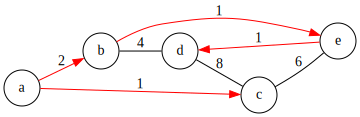

In [13]:
sptree = graphviz.Graph(
    "Dijkstra's Link State Algorithm",
    filename="spanning_tree",
    graph_attr={"rankdir": "LR"},
    node_attr={"shape": "circle"},
)

[sptree.node(v) for v in V]
[sptree.edge(u, v, dir="forward", label=str(E[(u, v)]), color="Red") for u, v in path]
[
    sptree.edge(u, v, label=str(E[(u, v)]))
    for (u, v) in edges
    if {u, v} not in map(set, path)
]

sptree